In [41]:
metadata = {
    'Author      ': 'Jay Annadurai',
    'Date        ': '14 Feb 2024',
    'Project     ': 'A1-Matrices',
    'Version     ':  1.0,
    'Description ': 'Reads and Compares Gene Expression Matrices in RPKM and Generates corresponding Correlation Matrices and  Correlation Heatmaps'
}

In [42]:
# Import Libraries
import pandas as pd  # Data Reading
import seaborn as sb  # Advanced Data Visualization
import matplotlib.pyplot as mplot  # Data Visualization
import numpy as numpy # Computation

In [43]:
# Input Matrix Files
matrices = ["matrix1", "matrix2"]
input_folder = "data/"
output_folder = "output/"

In [44]:
def read_matrix_to_df(folder: str, file_name: str, extension: str):
    # Function Reads the Matrix and Returns it as a Pandas DF
   
    # Read the TSV
    extension = "." + extension.lower()
    file_path = folder + file_name + extension
    matrix_df = pd.read_csv(file_path, sep='\t', header=0)

    # Drop the Extra Column Produced by Extraneous Delimiters
    matrix_df = matrix_df.drop(columns=['Unnamed: 13'])

    # Excluding the non-numeric column (assuming it's the first column)
    numeric_df = matrix_df.select_dtypes(include=[float, int])

    # Generate the 1D Vector of Values
    matrix_vector = numeric_df.values.flatten()

    # Return a Dict with the File Name, the Original DF, the Numeric DF, and the Flattened Vector
    return {"name": file_name, "df": matrix_df, "matrix": numeric_df, "vector": matrix_vector}

In [45]:
def data_to_correlation_matrix(data_df, matrix_name: str, digits=3) -> dict:
    # Function Returns a Correlation Matrix from a Numeric Data Matrix

    # Generate the Correlation Matrix
    correlation_matrix_df = data_df.corr()
    correlation_matrix_df = correlation_matrix_df.round(decimals=digits)
    
    # Generate the Vector of Values
    correlation_vector = correlation_matrix_df.values.flatten()
    
    
    # Generates a Table of Values in the Form X | Y | Correlation Coef
    def correlation_matrix_to_correlation_table(correlation_matrix_df: pd.DataFrame, matrix_row_name="X", matrix_column_name="Y", remove_redundancy=True)-> pd.DataFrame:
        # Generate a Table of Values in the Form Row | Column | Correlation_Coefficient
        
        # df.stack() method converts a DF with row labels and column labels in a 2D arrangement into a 1D arrangement
        # df.stack() yields a hierarchical structure with each row having all the values for that row compressed into it
        correlation_matrix_df_stacked = correlation_matrix_df.stack()
        # correlation_matrix_df_stacked

        # df.reset_index() converts the hierarchical structure into an indexed list instead with repeating rows
        correlation_table_df = correlation_matrix_df_stacked.reset_index()

        # Rename the Columns of the Correlation Table Dataframe
        correlation_table_df.columns  = [matrix_row_name, matrix_column_name, 'Correlation Coefficient']
        
        # Remove Redundant Values where the X and Y values are the same
        if remove_redundancy:
            # Remove Columns where the correlation is between the same variable which automatically yields a perfect correlation of 1
            correlation_table_df = correlation_table_df[correlation_table_df[matrix_row_name] != correlation_table_df[matrix_column_name]]
            
            # Remove Rows that Contain the same X and Y variable, just flipped
            # Initialize a list to contain the unique row and column pairs
            unique_column_row_pairs = []
            # Initializes a list to contain the rows to be removed
            rows_to_remove = []
            
            # Iterate through each row of the table
            for index, row in correlation_table_df.iterrows():
                # Create a set for the current row's pair
                # Leverage a set's nature to have no duplicate values
                # Must use a frozen set, frozenset([ ... ]), versus just a set, { ... }, as frozen sets are hashable
                # Frozen sets can be used or ordered tuples to be used in a list for a membership check
                current_column_row_pair = frozenset([row[matrix_row_name], row[matrix_column_name]])
            
                # Check if this current pair is unique and not already identified
                if current_column_row_pair not in unique_column_row_pairs:
                    # Identify the Pair as Unique
                    # This pair will now be unavailable to be added into the list again and will be marked for deletion if found again
                    unique_column_row_pairs.append(current_column_row_pair)

                # If not, mark this pair to be removed
                else: rows_to_remove.append(index)
            
            # Drop the rows marked for deletion
            correlation_table_df.drop(rows_to_remove, inplace=True)

        # correlation_table_df 
            
        # Return the Table of Correlation Coefficients
        return correlation_table_df
         
    # Generate a Table of Values in the Form Row | Column | Correlation_Coefficient
    correlation_table = correlation_matrix_to_correlation_table(correlation_matrix_df, "Cancer - X", "Cancer - Y", True)

    # Return the Dictionary
    return {"name": "correlation_"+matrix_name, "matrix": correlation_matrix_df, "vector": correlation_vector, "table": correlation_table}

In [46]:
def generate_correlation_matrix_heatmap(correlation_matrix, matrix_name: str, figure_ppi=400, output_folder_path=output_folder, figure_palette="mako"):
        # Function to Generate a Heatmap from a Correlation Matrix and Save It
        
        # Heatmap Plot
        mplot.figure(figsize=(6, 5), dpi=figure_ppi, edgecolor="#000000")
        mplot.title(matrix_name)
        
        # Turn on Value Annotations and Set Value Range from 0 to 1
        sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=figure_palette, vmin=0, vmax=1, linewidths=0.5, linecolor='black')

        # Path to the Output File
        output_file_path = output_folder_path + matrix_name + "_heatmap.png"
        print(f"Saving heatmap to {output_file_path}...")

        # Save the Figure
        mplot.savefig(output_file_path, dpi=figure_ppi, bbox_inches='tight', transparent=True)

Saving heatmap to output/correlation_matrix1_heatmap.png...
Saving heatmap to output/correlation_matrix2_heatmap.png...


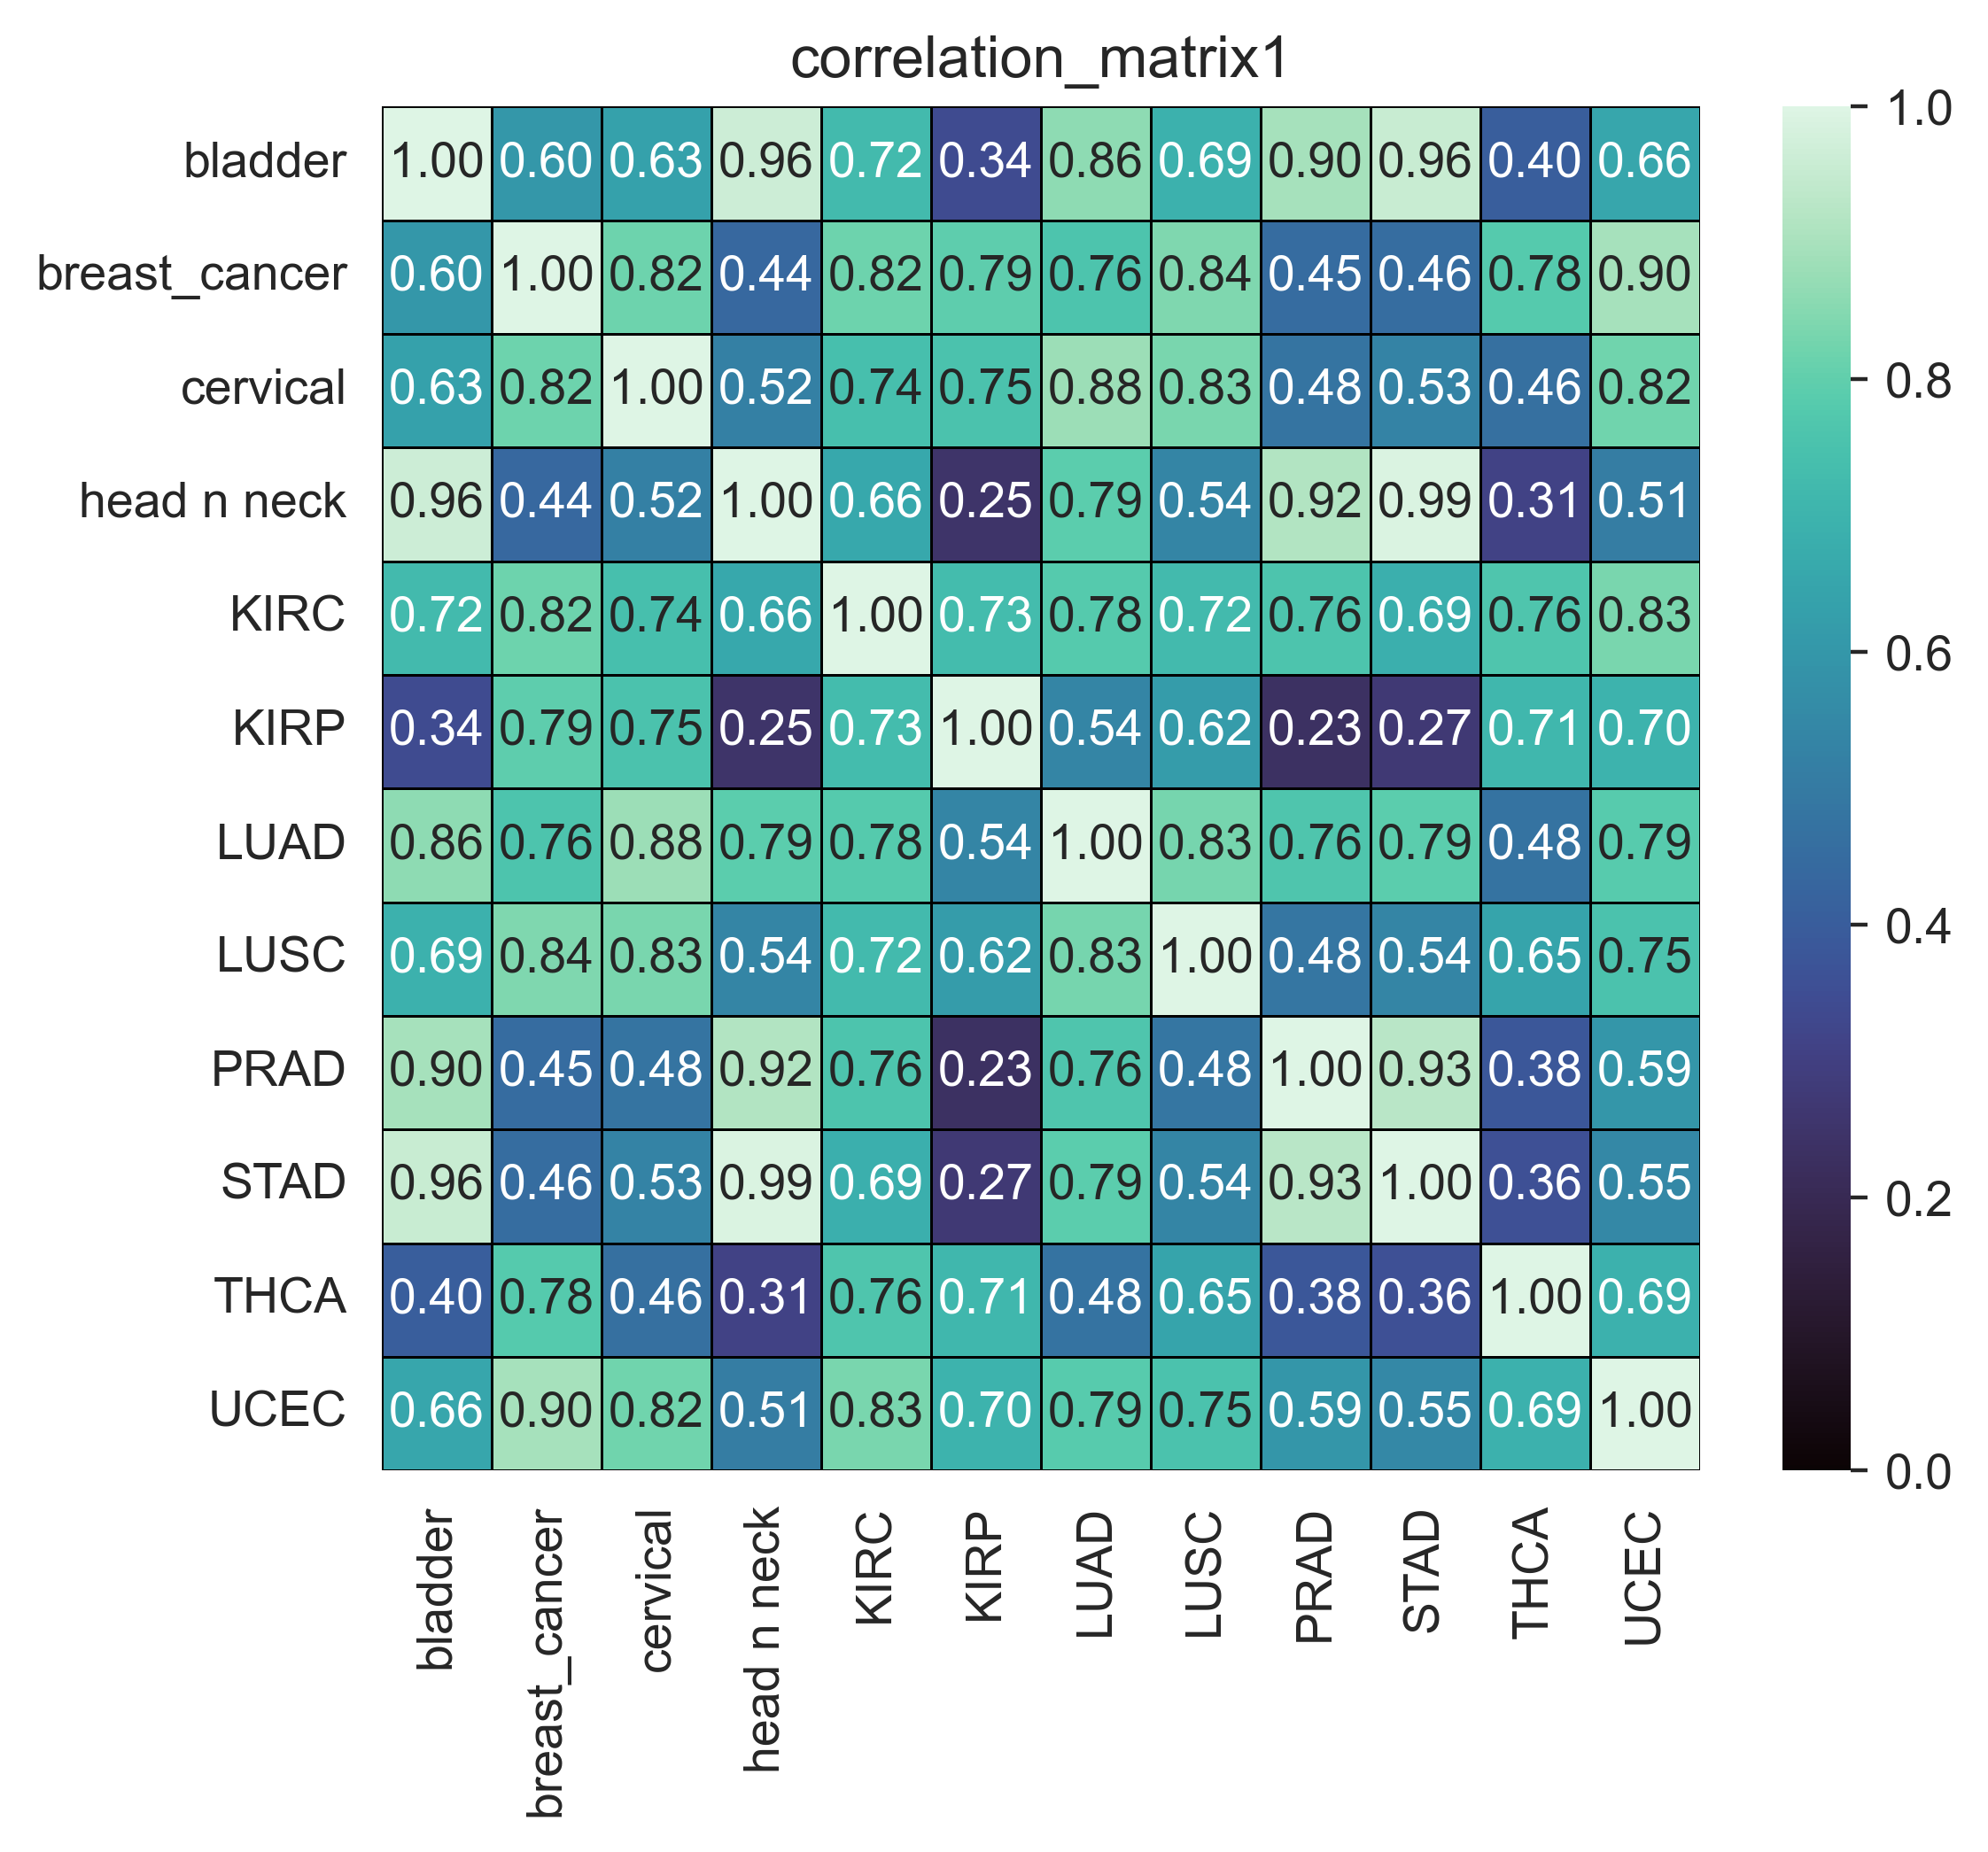

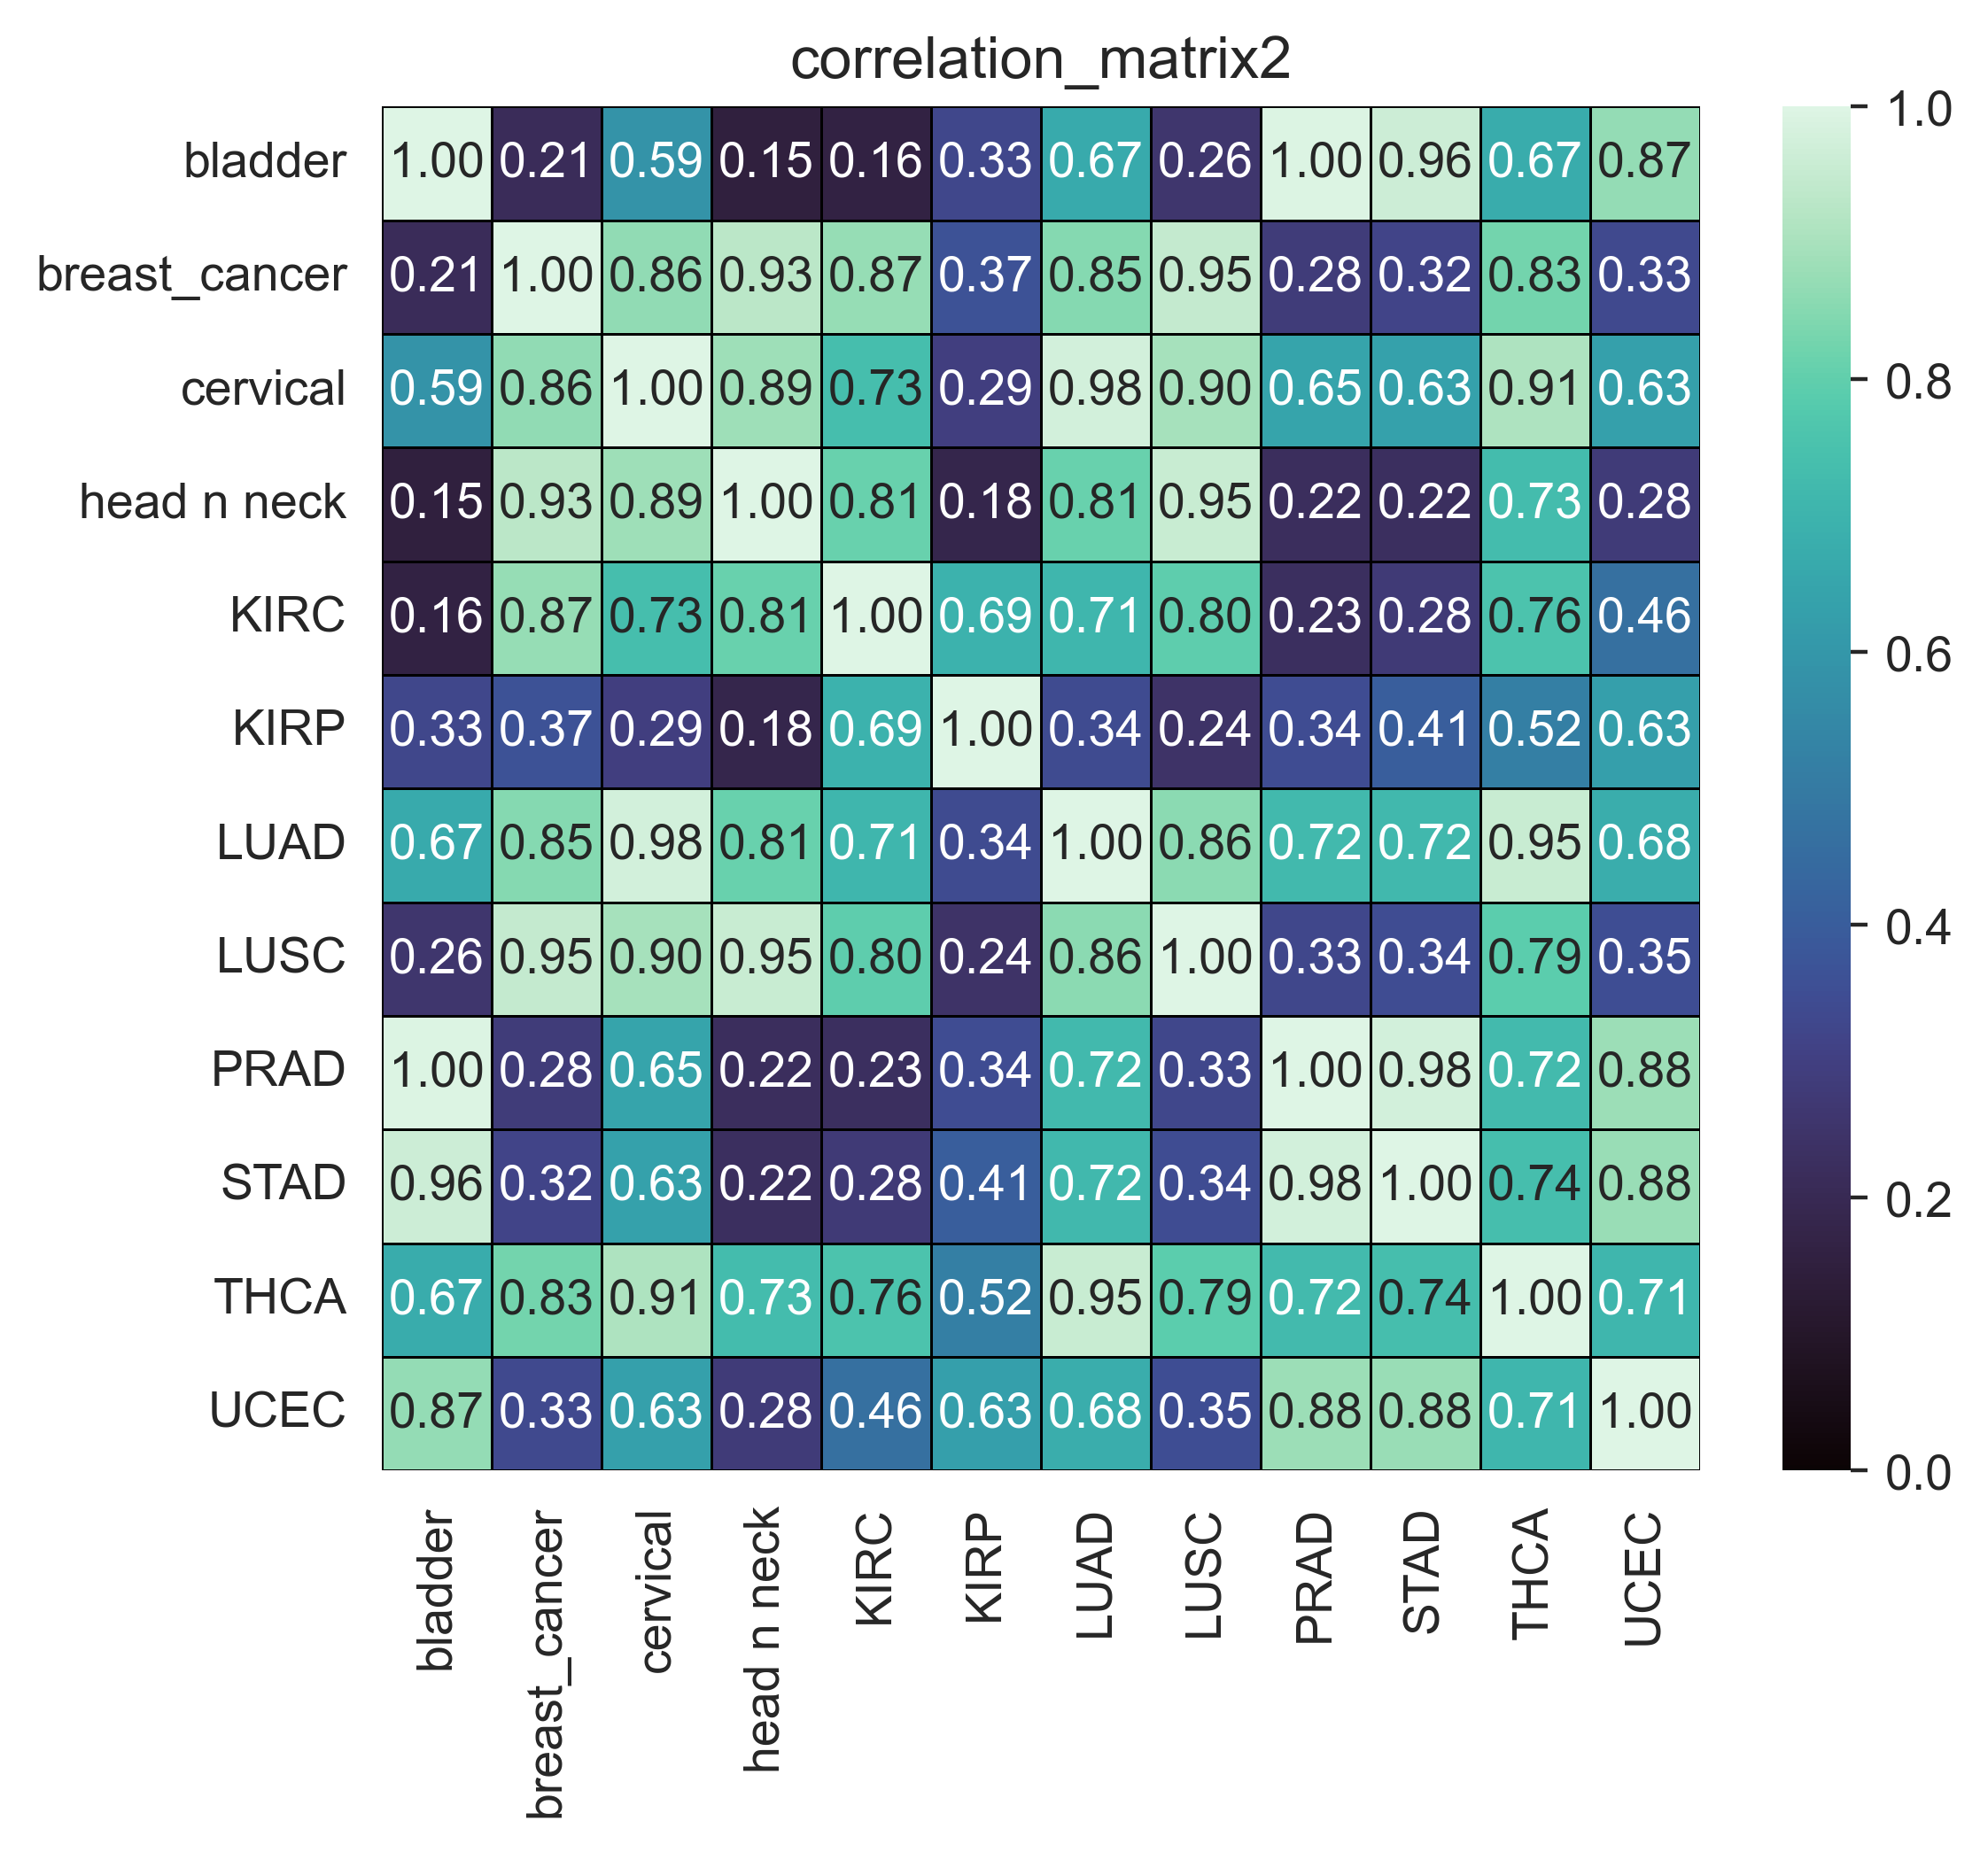

In [47]:
# Temporary List of Dictionaries in the format [{ name: val, matrix: val }, {...}]
correlation_matrices = []
original_matrices = []

# Generate Data Matrices and Correlation Matrices for Each Matrix File
for matrix_name in matrices:
    
    # Obtain the DF from the Matrix.txt
    matrix_dict = read_matrix_to_df(input_folder, matrix_name, "txt")
    original_matrices.append(matrix_dict)
    
    # Use the DF to generate a Correlation Matrix
    correlation_matrix_dict = data_to_correlation_matrix(matrix_dict["matrix"],matrix_dict["name"])

    # Generate and Save Heatmaps of Each Correlation Matrix
    generate_correlation_matrix_heatmap(correlation_matrix_dict["matrix"],correlation_matrix_dict["name"])
    
    # Bind the Correlation Matrix Dictionary to the Array of Correlation Matrix Dictionaries
    correlation_matrices.append(correlation_matrix_dict)


In [48]:
# PEARSON CORRELATION COEFFICIENT
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# 
# Method 1: Compute Pearson Correlation Coefficient from Flattened Original Data Matrices
direct_pearson_correlation_coefficient = numpy.corrcoef(original_matrices[0]["vector"],original_matrices[1]["vector"])[0,1]
print("Pearson Correlation Coefficient: " + str(round(direct_pearson_correlation_coefficient,3)))


Pearson Correlation Coefficient: 0.747


In [49]:
# ARCHIVED CODE
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Legacy: Unused
def merged_correlation_table_dfs(correlation_table_df1: pd.DataFrame, correlation_table_df2: pd.DataFrame)-> pd.DataFrame:
    # Function to merge two correlation table dfs, generated from correlation matrix dfs, together on the same rows and columns

    # # Reset index in case the X and Y columns are part of the index - Unnecessary
    # correlation_table_df1 = correlation_table_df1.reset_index()
    # correlation_table_df2 = correlation_table_df2.reset_index()

    # Grab the X & Y columns of each dataframe which should be the first 2 columns
    correlation_matrix_df1_xy_columns = correlation_table_df1.columns[:2].tolist()
    correlation_matrix_df2_xy_columns = correlation_table_df2.columns[:2].tolist()

    # Break the Function if the Columns are not the same
    if correlation_matrix_df1_xy_columns != correlation_matrix_df2_xy_columns:
        exit("Correlation Table DFs are not Comparable")

    # Merge the Dataframes on the X and Y columns which correspond to the rows and columns of the original correlation matrix
    # Suffixes apply a label to non-merged columns
    merged_correlation_df = pd.merge(correlation_table_df1, correlation_table_df2, on=correlation_matrix_df1_xy_columns, suffixes=(' Mx 1', ' Mx 2'))

    # Return the Table DF which should have the format X | Y | Correlation Coefficient Mx 1 | Correlation Coefficient Mx 1
    return merged_correlation_df


# Legacy: Unused
def pearson_correlation_of_correlations(merged_correlation_table_df: pd.DataFrame)-> float:
    # Get the Pearson Correlation Coefficient of the Two Correlation Coefficient Columns

    # Get the names of the last two columns dynamically
    correlation_coefficient_columns = merged_correlation_df.columns[-2:]

    # Calculate and return the Pearson correlation coefficient
    correlation_coefficient = merged_correlation_df[correlation_coefficient_columns[0]].corr(merged_correlation_df[correlation_coefficient_columns[1]])

    # Return the Pearson Correlation Coefficient
    return correlation_coefficient

# # Method 2: Align the Correlation Coefficients in a Non-Redundant Table and then take the Correlation Coefficient of the Two Columns
# merged_correlation_df = merged_correlation_table_dfs(correlation_matrices[0]["table"], correlation_matrices[1]["table"])
# aligned_pearson_correlation_coefficient = pearson_correlation_of_correlations(merged_correlation_df)
# print("The Aligned Pearson Correlation Coefficient:"+str(aligned_pearson_correlation_coefficient))